In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'ASETRI'
    elif x == 1:
        return 'EPTBOT'
    elif x == 2:
        return 'MYOEMA'
    elif x == 3:
        return 'PIPKUH'
    elif x == 4:
        return 'RHIMUS'
    elif x == 5:
        return 'RHYNAS'
    elif x == 6:
        return 'ROUAEG'
    elif x == 7:
        return 'TAPPER'
    else:
        return 'Unknown'

In [4]:
image_folder_path = '../data/STFT'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1805
TAPPER     429
PIPKUH     303
RHYNAS     271
EPTBOT     131
ROUAEG     121
MYOEMA     114
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/STFT'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('L') 
    spectrogram = spectrogram.resize((341,224)) 
    spectrogram = np.array(spectrogram)
    spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))
    


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3199, 224, 341, 1)
(3199,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)



<h2>Model Building</h2>

In [8]:

   def build_current_model():
    inp = Input(shape=(224,341,1))
    
    c1 = Convolution2D(filters=128,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)

    
    c2 = Convolution2D(filters=256,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c2 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c3 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.4)(mpool)
    
    f = Flatten()(mpool)
    
    x_dense = Dense(2048)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)

    
    x_dense = Dense(1024)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)
    
    x_dense = Dense(512)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adam(lr=0.003), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model




In [9]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 341, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 171, 128)     6400      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 171, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 112, 171, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 86, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 86, 128)       0         
_________

In [ ]:
tf.keras.utils.plot_model(model, "Model2V8.png", show_shapes=True)

In [10]:

my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=25,verbose=1, mode='min',restore_best_weights=True)]

history = model.fit(X_train, Y_train, 
              epochs = 100, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 8,
                 callbacks=my_callbacks)

history_info = history.history



Train on 2303 samples, validate on 256 samples
Epoch 1/100
2303/2303 [==============================] - 11s 5ms/sample - loss: 1.7042 - acc: 0.5072 - val_loss: 1.4095 - val_acc: 0.5898
Epoch 2/100
2303/2303 [==============================] - 9s 4ms/sample - loss: 1.4815 - acc: 0.5371 - val_loss: 1.9278 - val_acc: 0.5508
Epoch 3/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 1.3138 - acc: 0.5901 - val_loss: 1.1212 - val_acc: 0.6133
Epoch 4/100
2303/2303 [==============================] - 9s 4ms/sample - loss: 1.1072 - acc: 0.6109 - val_loss: 6.6941 - val_acc: 0.3047
Epoch 5/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.9700 - acc: 0.6769 - val_loss: 1.3852 - val_acc: 0.4648
Epoch 6/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 1.0067 - acc: 0.6652 - val_loss: 1.3040 - val_acc: 0.5039
Epoch 7/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.9218 - acc: 0.6795 - val_loss: 0.8388 - val_a

<h2>Evaluation (Basic)</h2>

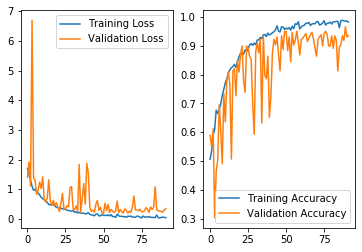

In [11]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [12]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[  5   0   0   0   0   0   0   0]
 [  0  20   0   0   2   0   4   0]
 [  0   0  12   0   5   0   1   5]
 [  0   0   0  52   2   1   0   6]
 [  0   0   0   0 353   0   1   7]
 [  0   1   0   0   0  50   1   2]
 [  0   0   0   0   5   0  18   1]
 [  0   0   0   0   3   0   0  83]]


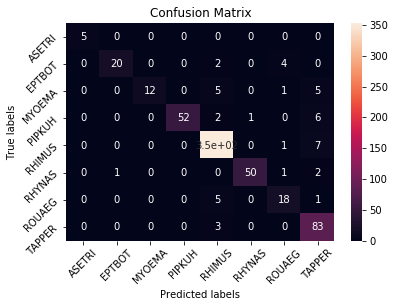

In [13]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['ASETRI','EPTBOT','MYOEMA','PIPKUH','RHIMUS','RHYNAS', 'ROUAEG', 'TAPPER']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [14]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9265625


In [15]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

      ASETRI       1.00      1.00      1.00         5
      EPTBOT       0.95      0.77      0.85        26
      MYOEMA       1.00      0.52      0.69        23
      PIPKUH       1.00      0.85      0.92        61
      RHIMUS       0.95      0.98      0.97       361
      RHYNAS       0.98      0.93      0.95        54
      ROUAEG       0.72      0.75      0.73        24
      TAPPER       0.80      0.97      0.87        86

    accuracy                           0.93       640
   macro avg       0.93      0.85      0.87       640
weighted avg       0.93      0.93      0.92       640



In [16]:
##ROC AUC Scores
from sklearn.metrics import roc_auc_score
print('One-vs-One ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


print()
print('One-vs-Rest ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

One-vs-One ROC AUC scores:
0.9865932061936444 (macro)
0.9913675864745162 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.9926137628746063 (macro)
0.992654488400009 (weighted by prevalence)


/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


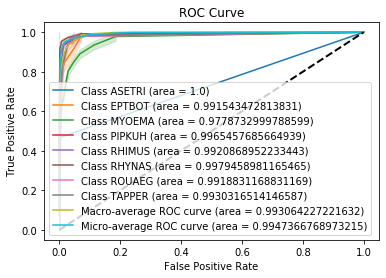

In [17]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

### ROC Curves + AUC per class

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve')

fpr = [0] * 8
tpr = [0] * 8
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], Y_pred[:,i])
    auc_val = auc(fpr[i], tpr[i])
    sns.lineplot(x=fpr[i],y=tpr[i],ax=axs, label='Class '+ getSpecies(i) +' (area = ' + str(auc_val) + ')', legend='brief')

#### Micro/Macro ROC Curves + AUC over all classes

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(8)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(8):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 8

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)
fpr_micro, tpr_micro,_ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

sns.lineplot(x=fpr_macro,y=tpr_macro,ax=axs, label='Macro-average ROC curve (area = ' + str(roc_auc_macro) + ')', legend='brief')
sns.lineplot(x=fpr_micro,y=tpr_micro,ax=axs, label='Micro-average ROC curve (area = ' + str(roc_auc_micro) + ')', legend='brief')

## Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)

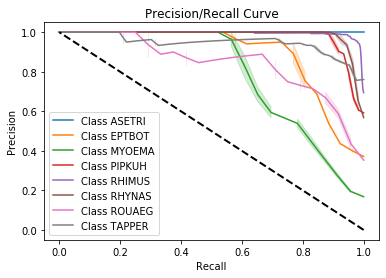

In [18]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve')

prec = [0] * 8
rec = [0] * 8
for i in range(8):
    prec[i], rec[i], _ = precision_recall_curve(Y_test[:,i], Y_pred[:,i])
    sns.lineplot(x=rec[i],y=prec[i],ax=axs, label='Class '+ getSpecies(i), legend='brief')

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [ ]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=25,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]

       
    # create and fit the model
   
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.1,
              verbose=1,
            callbacks=my_callbacks)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['ASETRI','EPTBOT','MYOEMA','PIPKUH','RHIMUS','RHYNAS', 'ROUAEG', 'TAPPER']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2303 samples, validate on 256 samples
Epoch 1/100
2303/2303 [==============================] - 10s 5ms/sample - loss: 1.6295 - acc: 0.5276 - val_loss: 1.8384 - val_acc: 0.5273
Epoch 2/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 1.3663 - acc: 0.5719 - val_loss: 1.6396 - val_acc: 0.5312
Epoch 3/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 1.2341 - acc: 0.5914 - val_loss: 1.0213 - val_acc: 0.6523
Epoch 4/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 1.0903 - acc: 0.6231 - val_loss: 1.2619 - val_acc: 0.5156
Epoch 5/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.9492 - acc: 0.6648 - val_loss: 1.2172 - val_acc: 0.5312
Epoch 6/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.9552 - acc: 0.6652 - val_loss: 1.2657 - val_acc: 0.5391
Epoch 7/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.8653 - acc: 0.6956 - val_loss: 0.9665 - val

2303/2303 [==============================] - 10s 4ms/sample - loss: 0.2277 - acc: 0.9292 - val_loss: 0.3017 - val_acc: 0.9258
Epoch 39/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.1927 - acc: 0.9327 - val_loss: 1.1151 - val_acc: 0.7812
Epoch 40/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.2019 - acc: 0.9327 - val_loss: 0.5131 - val_acc: 0.8203
Epoch 41/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.1908 - acc: 0.9288 - val_loss: 0.3388 - val_acc: 0.8945
Epoch 42/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.1570 - acc: 0.9462 - val_loss: 0.4380 - val_acc: 0.8945
Epoch 43/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.2021 - acc: 0.9310 - val_loss: 1.3865 - val_acc: 0.7461
Epoch 44/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.1595 - acc: 0.9479 - val_loss: 0.3547 - val_acc: 0.8906
Epoch 45/100
2303/2303 [================

2303/2303 [==============================] - 10s 4ms/sample - loss: 0.1036 - acc: 0.9674 - val_loss: 0.2646 - val_acc: 0.9297
Epoch 67/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.1210 - acc: 0.9627 - val_loss: 0.2231 - val_acc: 0.9297
Epoch 68/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.0665 - acc: 0.9770 - val_loss: 0.2047 - val_acc: 0.9453
Epoch 69/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.0879 - acc: 0.9696 - val_loss: 0.1129 - val_acc: 0.9609
Epoch 70/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.0761 - acc: 0.9722 - val_loss: 0.1790 - val_acc: 0.9414
Epoch 71/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.0600 - acc: 0.9805 - val_loss: 0.2938 - val_acc: 0.9336
Epoch 72/100
2303/2303 [==============================] - 10s 4ms/sample - loss: 0.0923 - acc: 0.9705 - val_loss: 0.8318 - val_acc: 0.8164
Epoch 73/100
2303/2303 [================

2304/2304 [==============================] - 10s 4ms/sample - loss: 0.3191 - acc: 0.8924 - val_loss: 0.5451 - val_acc: 0.8164
Epoch 26/100
2304/2304 [==============================] - 10s 4ms/sample - loss: 0.3348 - acc: 0.8876 - val_loss: 0.8279 - val_acc: 0.7109
Epoch 27/100
2304/2304 [==============================] - 10s 4ms/sample - loss: 0.2846 - acc: 0.8971 - val_loss: 7.9521 - val_acc: 0.2344
Epoch 28/100
2304/2304 [==============================] - 10s 4ms/sample - loss: 0.3295 - acc: 0.8906 - val_loss: 0.4464 - val_acc: 0.8594
Epoch 29/100
2304/2304 [==============================] - 10s 4ms/sample - loss: 0.2623 - acc: 0.9154 - val_loss: 0.2978 - val_acc: 0.9062
Epoch 30/100
2304/2304 [==============================] - 10s 4ms/sample - loss: 0.2493 - acc: 0.9193 - val_loss: 0.3094 - val_acc: 0.8906
Epoch 31/100
2304/2304 [==============================] - 10s 4ms/sample - loss: 0.2344 - acc: 0.9193 - val_loss: 1.5804 - val_acc: 0.5977
Epoch 32/100
2304/2304 [================

In [20]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.96666667 0.94074074 0.80074108 0.93077813 0.97541146 0.96290305
 0.79093391 0.94850032]
precision sdev by class [0.06666667 0.07257747 0.05857484 0.03235642 0.00853052 0.02590879
 0.09180693 0.03994362]
macro precision mean 0.9145844176192618
macro precision sdev 0.01636776795192656
recall mean [0.92       0.86267806 0.73873518 0.95398907 0.98227147 0.92619529
 0.87833333 0.93012312]
recall sdev [0.09797959 0.03027995 0.11592825 0.0317437  0.0108847  0.03704095
 0.14497126 0.03519763]
macro recall mean 0.8990406897837048
macro recall sdev 0.014402609403920567
f1 mean [0.93737374 0.89818888 0.76512179 0.94155018 0.97873599 0.94337856
 0.81821428 0.93780142]
f1 sdev [0.05166348 0.03571695 0.07930177 0.01955277 0.00198817 0.0167987
 0.06640246 0.0104557 ]
macro f1 mean 0.9025456066293008
macro f1 sdev 0.00753286898713666
accuracy mean 0.9496728286384977
accuracy sdev 0.003171158366443506


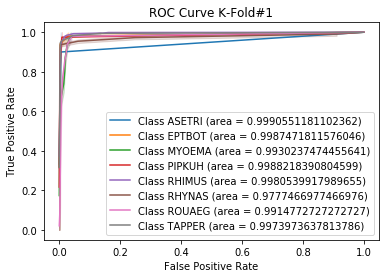

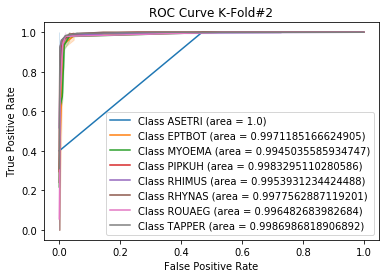

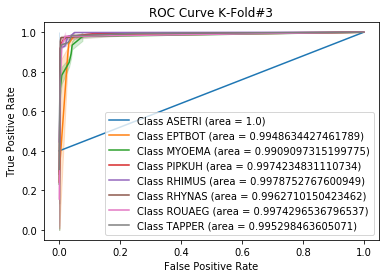

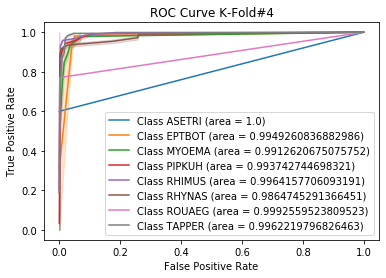

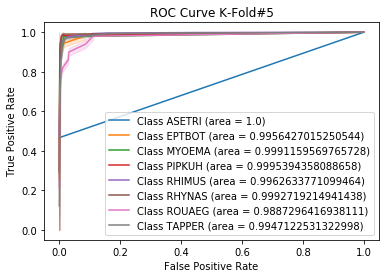

In [21]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

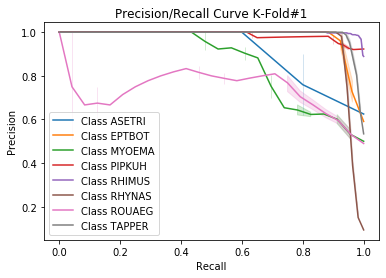

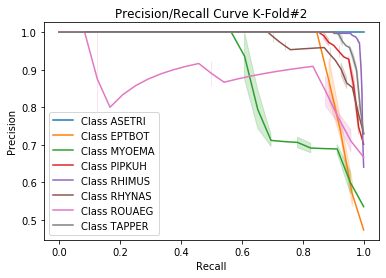

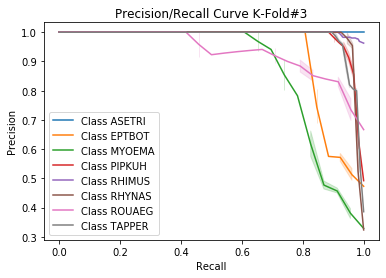

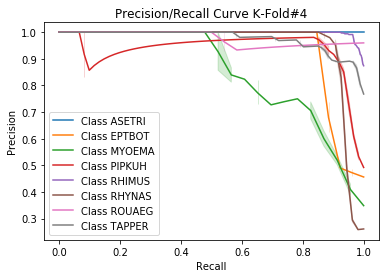

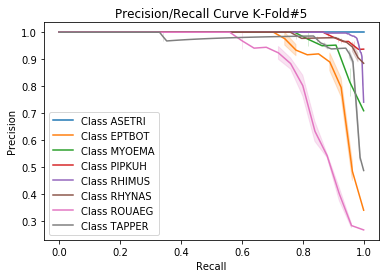

In [22]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  4   0   0   0   1   0   0   0]
 [  0  23   0   0   0   1   2   0]
 [  0   0  16   2   0   0   5   0]
 [  0   0   0  60   0   0   0   0]
 [  0   0   2   0 358   0   1   0]
 [  0   0   0   2   0  51   2   0]
 [  0   0   2   1   0   0  21   0]
 [  0   0   0   0  10   0   1  75]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  23   0   0   0   1   2   0]
 [  0   0  14   5   2   0   1   1]
 [  0   0   0  59   1   1   0   0]
 [  0   1   1   0 353   0   3   3]
 [  0   3   1   3   0  47   0   0]
 [  0   0   1   0   0   0  23   0]
 [  0   0   0   0   3   0   1  82]]


Confusion Matrix K-Fold #3

[[  4   0   1   0   0   0   0   0]
 [  0  21   0   0   4   0   1   0]
 [  0   0  17   1   1   0   3   1]
 [  0   0   1  56   2   1   1   0]
 [  0   0   0   0 360   0   0   1]
 [  0   0   1   1   0  51   1   0]
 [  0   0   1   0   0   0  23   0]
 [  0   0   0   0   7   0   1  78]]


Confusion Matrix K-Fold #4

[[  5   0   0   0   0   0   0   0]
 [  

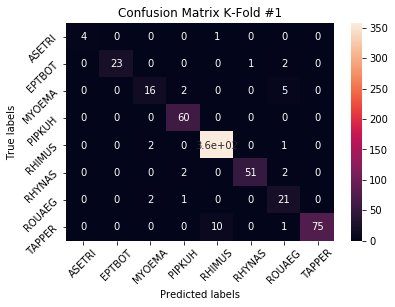

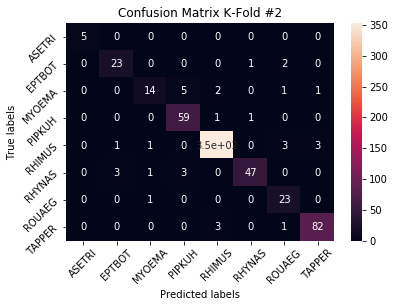

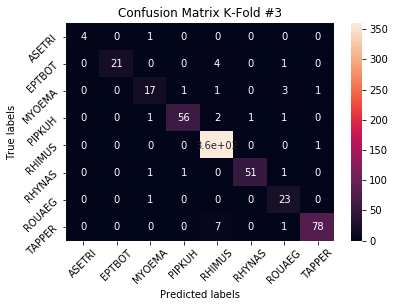

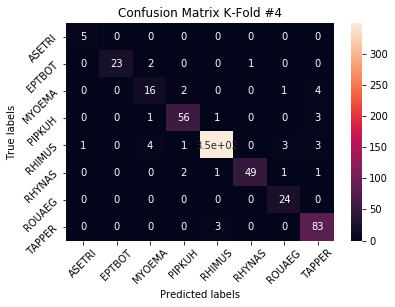

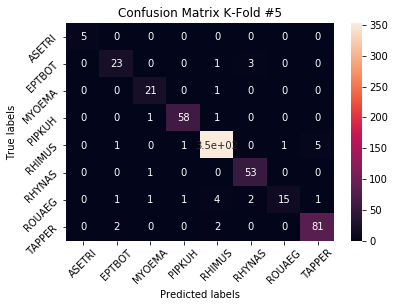

In [23]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);
    

sum of all confuion matrices
 [[  23    0    1    0    1    0    0    0]
 [   0  113    2    0    5    6    5    0]
 [   0    0   84   10    4    0   10    6]
 [   0    0    3  289    5    2    1    3]
 [   1    2    7    2 1773    0    8   12]
 [   0    3    3    8    1  251    4    1]
 [   0    1    5    2    4    2  106    1]
 [   0    2    0    0   25    0    3  399]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  22   0   0   1   1   1   0]
 [  0   0  16   2   0   0   2   1]
 [  0   0   0  57   1   0   0   0]
 [  0   0   1   0 354   0   1   2]
 [  0   0   0   1   0  50   0   0]
 [  0   0   1   0   0   0  21   0]
 [  0   0   0   0   5   0   0  79]]


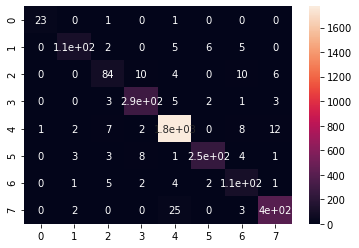

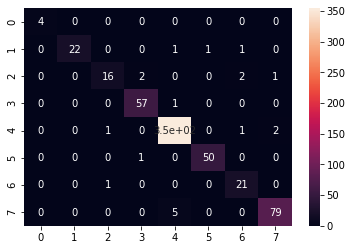

In [24]:
## Plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

<h2>Storing/Loading history and model to file</h2>

In [ ]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [ ]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [ ]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model